In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/instant-gratification/sample_submission.csv
/kaggle/input/instant-gratification/train.csv
/kaggle/input/instant-gratification/test.csv


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [5]:
train = pd.read_csv("/kaggle/input/instant-gratification/train.csv")
test = pd.read_csv("/kaggle/input/instant-gratification/test.csv")
submission = pd.read_csv("/kaggle/input/instant-gratification/sample_submission.csv")

# EDA

In [6]:
print(train.shape)
print(test.shape)

(262144, 258)
(131072, 257)


In [7]:
# 정답 불균형 체크
print(train["target"].value_counts())

target
1    131131
0    131013
Name: count, dtype: int64


<Axes: >

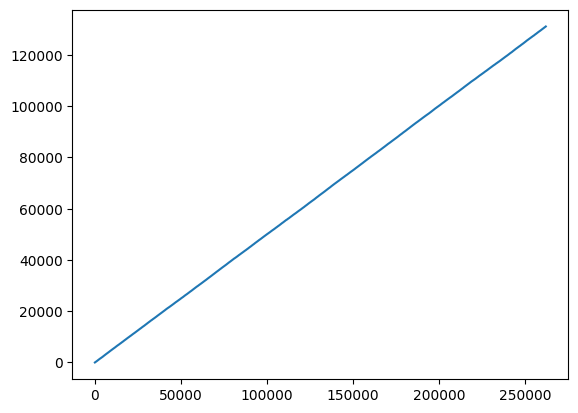

In [8]:
# 정답이 어느 부분에 쏠려있는지 확인
# 누출이라고 함
train["target"].cumsum().plot()

In [9]:
# null 값이 얼마나 되는지 확인 
train.isnull().sum().sum()

0

In [10]:
train.dtypes.value_counts()

float64    255
int64        2
object       1
Name: count, dtype: int64

In [11]:
# 데이터의  모든 열이 익명화 되어있다.
# 일단 확인
train.select_dtypes(include=["object", "int64"]).head()

,id,wheezy-copper-turtle-magic,target
0,707b395ecdcbb4dc2eabea00e4d1b179,99,0
1,5880c03c6582a7b42248668e56b4bdec,52,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,230,1
3,e350f17a357f12a1941f0837afb7eb8d,78,0
4,a8f910ea6075b6376af079055965ff68,497,0


In [14]:
# id, target을 제외한 train의 열 선택
train_columns = [c for c in train.columns if c not in ["id", "target"]]

In [15]:
# 중복되는 값 체크
train[train_columns].nunique()

muggy-smalt-axolotl-pembus              254322
dorky-peach-sheepdog-ordinal            254588
slimy-seashell-cassowary-goose          254356
snazzy-harlequin-chicken-distraction    254576
frumpy-smalt-mau-ordinal                254330
                                         ...  
jumpy-thistle-discus-sorted             254261
muggy-turquoise-donkey-important        254366
blurry-buff-hyena-entropy               254345
bluesy-chocolate-kudu-fepid             254329
gamy-white-monster-expert               254192
Length: 256, dtype: int64

In [16]:
# 25만개 이상의 데이터가 대부분인 것 같지만 25만개보다 작은 데이터 있는지 체크
print(np.where(train[train_columns].nunique()< 250000))

(array([146]),)


In [17]:
# 해당 column 출력
print(train_columns[146])

wheezy-copper-turtle-magic


In [18]:
train["wheezy-copper-turtle-magic"].nunique()

512

In [19]:
print(train["wheezy-copper-turtle-magic"].value_counts().mean())

512.0


In [20]:
train["wheezy-copper-turtle-magic"].value_counts().rename_axis("wheezy-copper-turtle-magic").reset_index(name="counts")

,wheezy-copper-turtle-magic,counts
0,51,570
1,489,556
2,298,554
3,135,554
4,245,553
...,...,...
507,277,476
508,215,475
509,108,472
510,42,471


In [24]:
train_columns = [
    c
    for c in train.columns
    if c not in ["id", "target", "wheezy-copper-turtle-magic"]
]
describe_train = train[train_columns].describe().T.drop("count", axis=1)
cmap = sns.diverging_palette(5, 250, as_cmap=True)
describe_train.T.style.background_gradient(cmap, axis=1).format(precision=2)

/tmp/ipykernel_33/3218364299.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_0_df.replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_33/3218364299.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_1_df.replace([np.inf, -np.inf], np.nan, inplace=True)


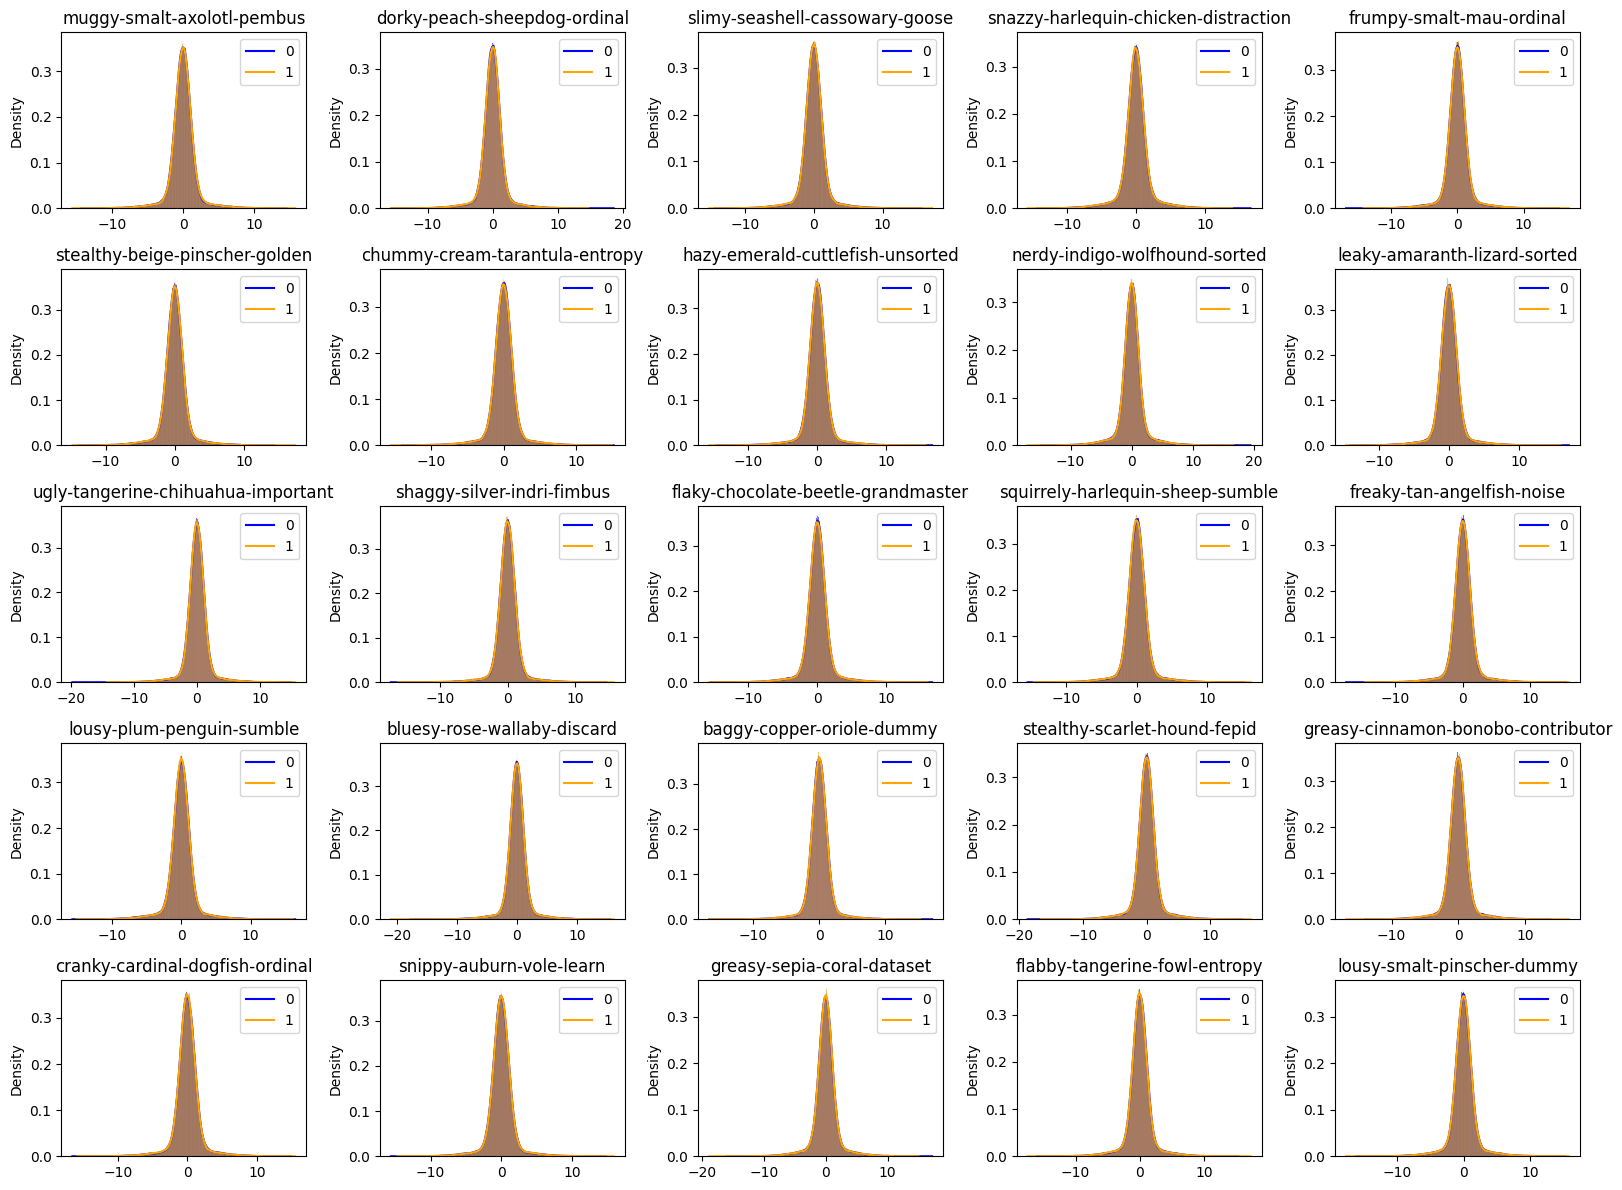

In [33]:
train_columns = [c for c in train.columns if c not in ["id", "target"]]

target_0_df = train.loc[train["target"] == 0]
target_1_df = train.loc[train["target"] == 1]

# inf 값을 NaN으로 변환
train.replace([np.inf, -np.inf], np.nan, inplace=True)
target_0_df.replace([np.inf, -np.inf], np.nan, inplace=True)
target_1_df.replace([np.inf, -np.inf], np.nan, inplace=True)

plt.figure(figsize=(16, 12))
for index, name in enumerate(train_columns[:25]):
    plt.subplot(5, 5, index + 1)
    sns.histplot(target_0_df[name].dropna(), kde=True, color='blue', label='0', stat="density")
    sns.histplot(target_1_df[name].dropna(), kde=True, color='orange', label='1', stat="density")
    plt.title(name)
    plt.xlabel("")
    plt.legend(["0","1"])
    
plt.tight_layout()
plt.show()

EDA과정을 요약
* 데이터가 어떤 형식으로 이루어졌는지 살펴본다.
* 정답 값의 비율을 확인
* 정답 값의 누출이 있는지 확인
* NULL 값 확인
* 범주형 변수와 수치형 변수를 나눠서 생각해봐야한다.
* feature는 정답 값과 연관 지어 생각하자.

# 스태킹

1단계 모델

In [ ]:
from sklearn.model_selection import KFold

# 훈련, 테스트 데이터 결과를 담을 변수 준비
oof_train = np.zeros((len(train), 1))
oof_test = np.zeros((len(test), 1))

fold = KFold(n_splits=3, random_state=42)

for trn_idx, val_idx in fold.split(train):
    x_tr, y_tr = train[trn_idx], target[trn_idx]
    x_val, y_val = train[val_idx], target[val_idx]
    model.fit(x_tr, y_tr)
    
    #검증 데이터 예측, val_idx로 선택하여 1/3 Fold 데이터만 변수에 저장
    oof_train[val_idx] = model.predict(x_val)
    
    # 학습된 모델로 테스트 데이터도 예측 수행
    # 3으로 나누느 이유는 3번 예측을 수행하기 때문에 평균을 내기 위함
    oof_test += model.predict(test) / 3

2단계 모델

In [34]:
# 모델 4개를 사용했다고 가정했을 때 다음과 같이 4개의 결과를 합쳐서
# 하나의 2단계 입력 값을 만든다.
train_2nd_input = np.concatenate(
(oof_train_model1, oof_train_model2, oof_train_model3, oof_train_model4), axi=1
)

test_2nd_input = np.concatenate(
(oof_test_model1, oof_test_model2, oof_test_model3, oof_test_model4), axi=1
)

# 2단계 예측 결과를 담을 변수를 만든다.
oof_train_2nd = np.zeros((len(train_2nd_input),1))
oof_test_2nd = np.zeros((len(tet_2nd_input),1))

for trn_idx, val_idx in fold.split(train):
    x_tr, y_tr = train_2nd_input[trn_idx], target[trn_idx]
    x_val, y_val = train_2nd_input[val_idx], target[val_idx]
    model.fit(x_tr, y_tr)
    
    # 마찬가지로 예측을 수행하고 결과를 저장
    oof_train_2nd[val_idx] = model.predict(x_val)
    test_2nd_input += model.predict(test_2nd_input) / 3

NameError: name 'oof_train_model1' is not defined

스태킹의 성능을 올리는 방법
* 모델에 들어가는 피처를 다르게 하여 다양성을 추가한다.
* 같은 모델이더라도 파라미터를 다르게 한다.
* 다양한 모델을 추가
* 2단계 모델의 입력에는 1단계 모델의 예측 값뿐만 아니라 원본 피처의 일부를 추가할 수 있다.
* 2단계 모델을 다양하게 시도해보고 여러 모델의 결과를 다시 스태킹하거나 평균 값을 취할 수 있다. 

### 2.3.4 솔루션 상세

In [ ]:
svnu_params = {
    "probability": True,
    "Kernel": "poly",
    "degree": 4,
    "gamma"L "auto",
    "nu":0.4,
    "coef0": 0.08
    "random_state": 4,
}

svnu2_params = {
    "probability": True,
    "Kernel": "poly",
    "degree": 2,
    "gamma"L "auto",
    "nu":0.4,
    "coef0": 0.08
    "random_state": 4,
}

qda_params = {"reg_param": 0.111}

svc_params = {
    "probability": True,
    "Kernel": "poly",
    "degree": 4,
    "gamma"L "auto",
    "random_state": 4,
}

neighbor_params = {"n_neighbors": 16}

lr_params = {"solver": "liblinear", "penalty": "l1", "C": 0.05, "random_state": 42}

In [ ]:
from sklearn import svm
from sklearn.discriminant_analysis import QuadraticDisicriminantAnlaysis
from sklearn import neighbors
from sklearn import linear_model

def run_model(clf_list, train, testm random_state, gmm_init_params="kmeans"):
    MODEL_COUNT = len(clf_list) 
    oof_train = np.zeros((len(train),MODEL_COUNT))
    oof_test = np.zeros((len(test),MODEL_COUNT))
    
nusvc_model = svm.NuSVC(**svnu_params)
nusvc2_model = svm.NuSVC(**svnu2_params)
qda_model = QuadraticDisicriminantAnlaysis(**qda_params)
svc_model = svm.SVC(**svc_params)
knn_model = neighbors.KNeighborsClassifier(**neighbor_params)
lr_model = linear_model.LogisticRegression(**lr_params)

model_list = [nusvc_model, nusvc2_model, qda_model, svc_model, knn_model, lr_model]
oof_train_kmeans_seed1, oof_test_kmeans_seed1 = run_model(model_list, train, test, 1)
oof_train_kmeans_seed2, oof_test_kmeans_seed2 = run_model(model_list, train, test, 2)

oof_train_random_seed1, oof_test_random_seed1 = run_model(model_list, train, test, 1,"random")
oof_train_random_seed2, oof_test_random_seed2 = run_model(model_list, train, test, 2,"random")
                    